In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
import numpy.polynomial
import ipywidgets as widgets
from IPython.display import display
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plab

# Define useful functions

In [182]:
# This function takes a (array of multiplication numbers) 
# and spectra (array of spectras of the target spectra [:,1,0], and the masks spectras [:,1,1] to [:,1,40]) 
# and calculates the difference in counts bewteen the desired spectra and the sumatory 
# of all the mask spectras multilyed by each constant. 
# This is the function to minimize in order to fit the mask proportions with a desired spectra

def loss(a, spectra):
  desired_spectra = spectra[:,1,0]
  for i in range (1, 40):
    current_spectra  = a[i] * spectra[:,1,i]
    if i == 1:
      total_spectra = current_spectra
    
    else:
      total_spectra = total_spectra + current_spectra

  diff = sum(abs(total_spectra[:]-desired_spectra[:]))#86:1982

  # for n in range (0,len(total_spectra)):
  #   diff = diff + abs(total_spectra[n]-desired_spectra[n])
  
  return (diff)


def ploter(a, spectra):
  
  for i in range (1, 40):
    current_spectra  = a[i] * spectra[:,1,i]
    if i == 1:
      total_spectra = current_spectra
    
    else:
      total_spectra = total_spectra + current_spectra

  return (total_spectra)

def closest(lst, K):
    
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def closest_indx(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx     


def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1)
    k_data_interpolation = interpolate.interp1d(k_data[:,0], k_data[:,1])
    irradiance = np.zeros(flame_data.shape)
    wl_min = np.amin(k_data[:,0])
    wl_max = np.amax(k_data[:,0])
    area_factor = 1#5.067/0.5543
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        #k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        #irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        if wl_max >= irradiance[i,0] >= wl_min:
          irradiance[i,1] = area_factor*flame_data[i,1]*k_data_interpolation(flame_data[i,0])/integration_time
        
    return irradiance

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [198]:
def spectra_to_photonnumb(input_spectra, central_wl):
    #solar_spectra_interp = interpolate.interp1d(solar_spectra[:,0], solar_spectra[:,1])
    input_spectra_interp = interpolate.interp1d(input_spectra[:,0], input_spectra[:,1])    
    if central_wl <= 200:
        #print(50)
        #wl_to_evaluate = np.arange(round(central_wl)-50, round(central_wl)+100, 1)  #wl increment = 1nm
        wl_to_evaluate = np.arange(min(input_spectra[:,0])+1, round(central_wl)+120, 1)  #wl increment = 1nm

    else:
        #print(20)
        wl_to_evaluate = np.arange(min(input_spectra[:,0])+1,max(input_spectra[:,0])-1, 1)  #wl increment = 1nm


    total_power = 0
    for i in range(len(wl_to_evaluate)):
        eval_wl = wl_to_evaluate[i]
        total_power = total_power + input_spectra_interp(eval_wl)
        
    total_photons = total_power*central_wl / 1240 /(1.6e-19)
    return total_photons
        


# Load data

## Load slits spectras

In [185]:
# Loading all the needed spectras for any other part in the program
# First, we load the full spectra of the lamp, without masks! (its not the "optimized" one sun spectra)
calibration_files_folder = 'Mask Calibration Files'
txt_filelist = os.path.join(os.getcwd(), calibration_files_folder)
#full_spectra = np.loadtxt('Full_spectrum_NoMask.txt', skiprows=1)

# Then we load the spectras for each mask
bg_spectra = np.loadtxt(os.path.join(calibration_files_folder,'Slit_number_0.txt'), skiprows=1) # and load the background (mask with full coverage) spectra
all_data_flame_spectra = np.zeros((len(bg_spectra),2,40)) # First create the array for all the spectras. 


for i in range (len(all_data_flame_spectra[0,0,:])): # In this for loop we load the spectra for the #i mask to the array all_data_spectra
  number = str(i)
  load_spectra = np.loadtxt(os.path.join(calibration_files_folder,'Slit_number_'+number+'.txt'), skiprows=1)
  all_data_flame_spectra [:,0,i] = load_spectra[:,0] # The x axis (wavelength in nm) at all_data_spectra [:,0,i]
  all_data_flame_spectra [:,1,i] = 1*(load_spectra[:,1])-bg_spectra[:,1]# The y axis (counts) with BG substraction at all_data_spectra [:,1,i]


#Now we pass the counts of the flame to irradiance with the calibration file
calibration_file_path = os.path.join(os.getcwd(), 'flame_to_irradiance_calibrationfile.txt')
flame_integration_time = 0.0006
all_data_irradiance = np.zeros(all_data_flame_spectra.shape)


for i in range(len(all_data_flame_spectra[0,0,:])):
  all_data_irradiance[:,:,i] = counts_to_irradiance(all_data_flame_spectra[:,:,i], flame_integration_time, calibration_file_path)

for i in range(len(all_data_irradiance[0,0,:])):
      for j in range(len(all_data_irradiance[:,0,0])):
            if all_data_irradiance[j,1,i] <= 0:
                all_data_irradiance[j,1,i] = 0


## Plot slits spectras

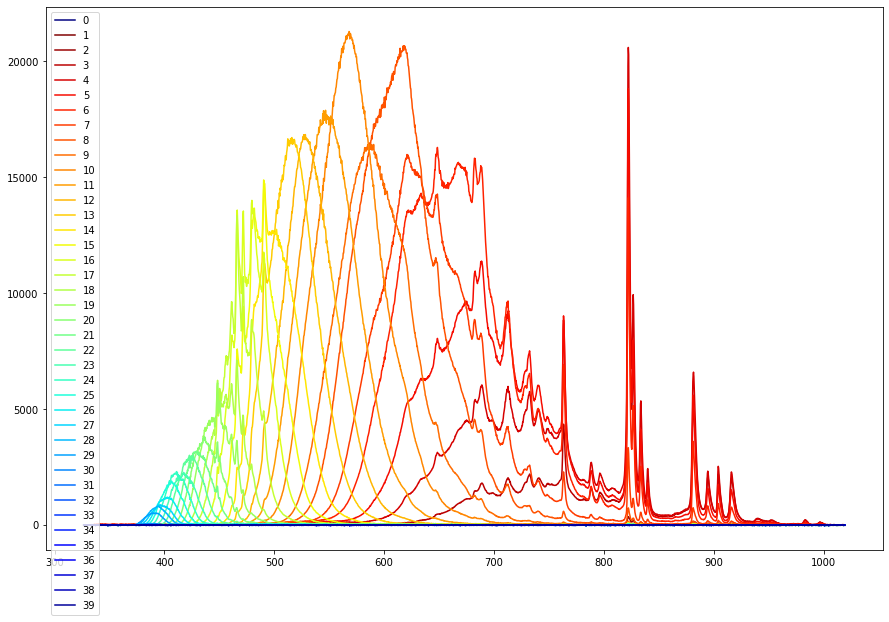

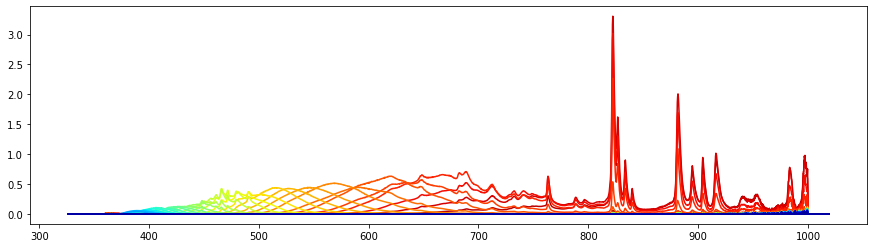

In [187]:
n = 40
colors = plt.cm.jet(np.linspace(0,1,n))
fig, ax = plt.subplots(figsize=(15,10))
fig, ax2 = plt.subplots(figsize=(15,4))

for j in range(n):    
    ax.plot(all_data_flame_spectra[:,0,j],all_data_flame_spectra[:,1,j], color = colors[-j], label=str(j))
    ax2.plot(all_data_irradiance[:,0,j],all_data_irradiance[:,1,j], color = colors[-j])
ax.legend()

#ax.plot(all_data_flame_spectra[:,0,0], ploter(np.ones(40),all_data_flame_spectra))

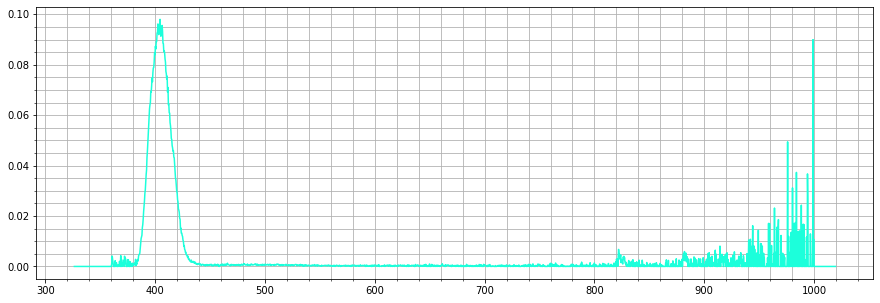

In [188]:
j = 25
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(all_data_irradiance[:,0,j],all_data_irradiance[:,1,j], color = colors[-j])
ax.tick_params(axis='x', which='minor',  bottom=True)
plt.minorticks_on()
plt.grid(which='both')
#plt.ylim(ymin=0)

In [189]:
EQE_central_wl = [1000,970,950,900,850,725,680,650,620, 590, 570, 545, 525, 515, 500, 485, 465, 460, 455, 445, 435, 425, 420, 415, 410, 405, 400]#, 395, 390, 385, 380]

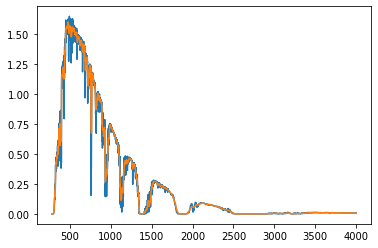

In [161]:
NREL_spectras = np.loadtxt('NREL_oficial_spectras.txt', skiprows=2)
AM15G_spectra = NREL_spectras[:,(0,2)]
fig, ax =plt.subplots()
ax.plot(AM15G_spectra[:,0], AM15G_spectra[:,1])
AM15G_spectra_fit = interpolate.interp1d(AM15G_spectra[:,0], smooth(AM15G_spectra[:,1],10))
ax.plot(AM15G_spectra[:,0], AM15G_spectra_fit(AM15G_spectra[:,0]))


In [117]:
EQE_measure = np.loadtxt('SOLS_EQE_SLITS_Jsc_Measure.txt', skiprows=1)
measure_Jsc = -EQE_measure[:,1]


C:\Users\MCASAD~1\AppData\Local\Temp/ipykernel_900/3412828621.py:10: RuntimeWarning: invalid value encountered in double_scalars
  actual_EQE = 100*(10*measure_Jsc[i])/(1*photon_number)/1.6e-19


[1000.  970.  950.  900.  850.  725.  680.  650.  620.  590.  570.  545.
  525.  515.  500.  485.  465.  460.  455.  445.  435.  425.  420.  415.
  410.  405.  400.]


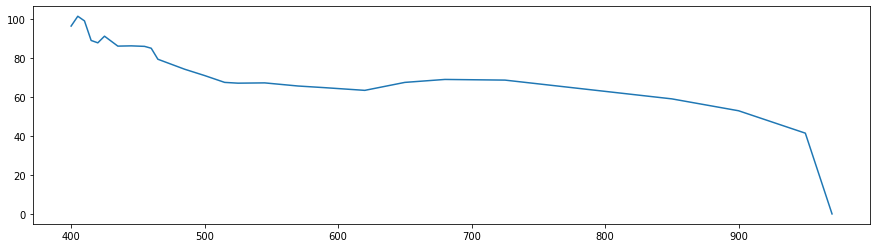

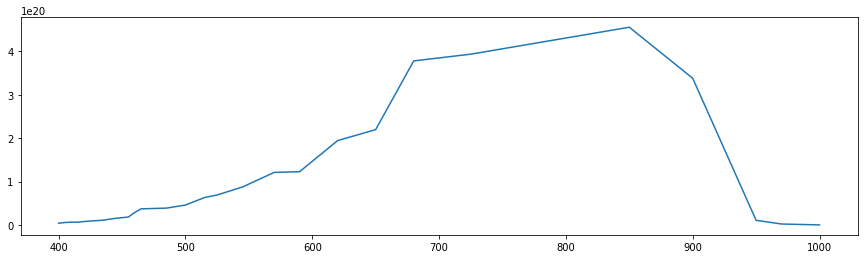

In [199]:
calculated_EQE = np.zeros((len(EQE_central_wl), 3))
# for i in range(len(measure_Jsc)):
#     wl_max=all_data_irradiance[closest_indx(all_data_irradiance[:,1,i],max(smooth(all_data_irradiance[:,1,8],200))),0,i]
#     calculated_EQE[i,0] = wl_max
calculated_EQE[:,0] = EQE_central_wl
for i in range(len(calculated_EQE[:,0])):
    #wl_max=all_data_irradiance[closest_indx(all_data_irradiance[:,1,i],max(smooth(all_data_irradiance[:,1,8],100))),0,i]
    cent_wl = calculated_EQE[i,0]
    photon_number = spectra_to_photonnumb(all_data_irradiance[:,:,i], cent_wl)
    actual_EQE = 100*(10*measure_Jsc[i])/(1*photon_number)/1.6e-19
    #calculated_EQE[i,0] = wl_max
    calculated_EQE[i,1] = actual_EQE
    calculated_EQE[i,2] = photon_number

fig, ax = plt.subplots(figsize=(15,4))
ax.plot(calculated_EQE[:,0], calculated_EQE[:,1])   
#plt.ylim(0,100)
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(calculated_EQE[:,0], calculated_EQE[:,2])

print(calculated_EQE[:,0])


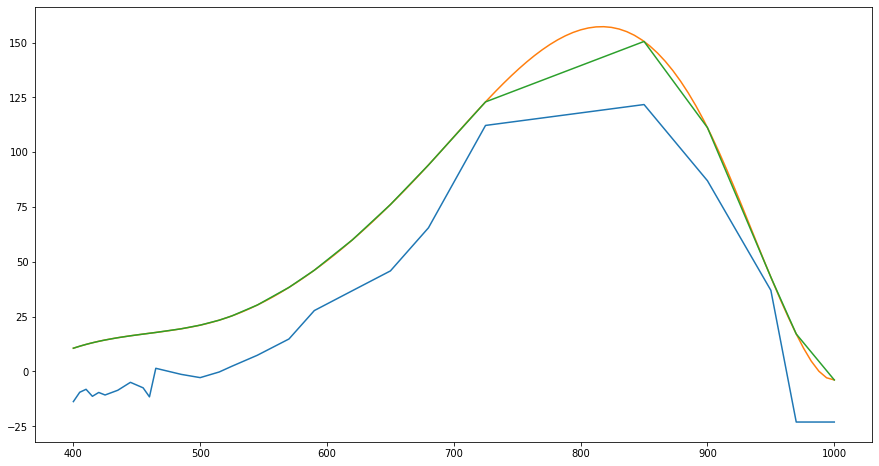

In [249]:
power_calib = np.loadtxt('SlitsPowerCalibration.txt', skiprows=1)
for i in range(len(calculated_EQE)):
    calculated_EQE [i,0] = EQE_central_wl[i]
    calculated_EQE[i,2] = power_calib[i,1]

power_calibration_fit = interpolate.UnivariateSpline(np.flip(calculated_EQE[:,0]), np.flip(calculated_EQE[:,2]), s=1000)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(np.flip(calculated_EQE[:,0]), np.flip(calculated_EQE[:,2]))
xxx = np.linspace(min(calculated_EQE[:,0]), max(calculated_EQE[:,0]), 100)
ax.plot(xxx, power_calibration_fit(xxx)+23)
new_power_calib = power_calibration_fit(calculated_EQE[:,0])+23
ax.plot(calculated_EQE[:,0], new_power_calib)

[-0.          0.          2.12427579 35.43311424 41.67643218 60.09560328
 80.75344952 59.39318829 65.6355309  57.79570284 72.03899427 70.59501198
 68.95622453 69.96403609 61.01933559 60.40321653 70.3981357  60.31650647
 39.94437073 35.94614508 27.75801869 26.40351825 23.59553755 20.53381712
 24.47991779 23.89813634 17.52162483]


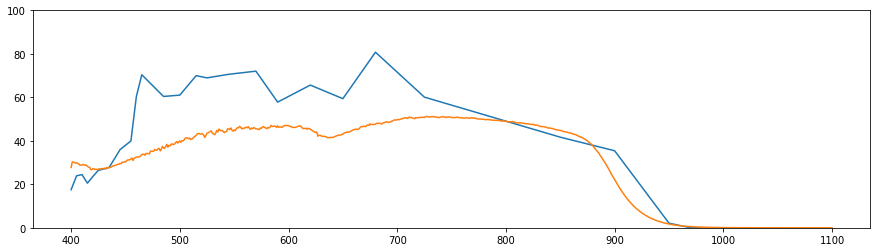

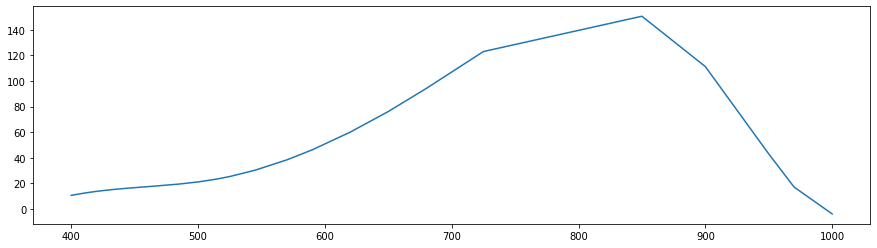

In [250]:
#here we will use the calibrated power measures from the thermopile

calculated_EQE = np.zeros((len(EQE_central_wl), 3))

for i in range(len(calculated_EQE)):
    calculated_EQE [i,0] = EQE_central_wl[i]
    calculated_EQE[i,2] = new_power_calib[i]
    calculated_EQE[i,1] = 100*(10*measure_Jsc[i]/1.6e-19)/(calculated_EQE[i,2]*calculated_EQE[i,0]/1240/1.6e-19)

real_EQE = np.loadtxt('MCV.211008.091410Y61.L.04.txt', skiprows=1)
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(calculated_EQE[:,0], calculated_EQE[:,1])
ax.plot(real_EQE[:,0], real_EQE[:,1])
plt.ylim(0,100)
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(calculated_EQE[:,0], calculated_EQE[:,2])
print(calculated_EQE[:,1])


